# Supplemental Information Section H
## Inference of thermodynamic model parameters using parallel tempering Markov chain Monte Carlo (MCMC).

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [1]:
# load in the usual tools
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import the project utils
import sys
sys.path.insert(0, '../')
import NB_sortseq_utils as utils
utils.set_plotting_style1()
from IPython.core.pylabtools import figsize

# The MCMC chains were saved with h5py
import h5py


# _purT_ promoter, thermodynamic model of simple repression.

- Sort-Seq data was from an experiment with strain MG1655, with cells grown in M9 minimal media with 0.5% glucose + 100 ng/ml adenine.

We begin with the _purT_ promoter. Here we identified an RNAP binding site
that is repressed by PurR, which binds between the -10 and -35 RNAP sites.
 Given the presence of only these two binding sites, we modeled
the promoter as having a simple repression architecture (Bintu _et al._, 2005}.
Some additional complexity arises due to the presence of other PurR binding
sites on the genome, and the allosteric dependence of a purine metabolite for
co-repression. Following the approach of  Weinert _et al._
(Weinert _et al._, 2014), this can be quantitatively described by,

\begin{equation}
P_{bound} = \frac{\lambda_p e^{-\beta \varepsilon_p}} {1 +
\lambda_p e^{-\beta \varepsilon_p} + \lambda_r e^{-\beta \varepsilon_r}}.
\end{equation}
Here $\lambda_p$ and $\lambda_r$ represent the fugacity, which describes the
relative availability of RNAP and PurR, respectively, to bind their binding
sites. These parameters depend on the concentration of each protein (through
their chemical potentials), and for PurR, will also depend on its allosteric
state. $\varepsilon_p$ and $\varepsilon_r$ represent the binding energies of
RNAP and PurR to their binding sites, respectively.

We can also describe each
binding energy through the gauge-fixed energy matrix prediction (see Supplemental
information section H), which is
multiplied by a scale factor and additive shift  (e.g. $\varepsilon_r = A_r
\cdot x_r + B_r$, where $A_r$ is the scale factor, $x_r$ is the energy matrix
prediction, and $B_r$ is the additive shift). To being fitting to the model
described by the equation above, we first inferred the  energy
matrices for RNAP and PurR following the MCMC procedure noted above.  We then
performed a second MCMC to fit the remaining thermodynamic parameters.  In
this second MCMC we sampled using error-model-averaged likelihood against the
posterior $p(P_{bound} \vert \{S, f\})$. This allowed us to infer the
following parameters below: $A_r= -11.55 k_B T$, $\lambda_r e^{-\beta B_r} =
e^{0.64}$, and $A_p= 2.4 k_B T$, where  $A_p$ is the RNAP scale factor. Note
that in this second MCMC, we performed parallel tempering MCMC  (using the
PTSampler in package emcee, Mackey _et al._, 2013) to better
sample the posterior distributions of our thermodynamic parameters (see
supplemental material of Kinney _et al_, 2010).

We can first take a look at the posterior probability values (i.e. the mutual information; Kinney et al. 2010) from our MCMC chains. All of these seem to be single peaked, except chain0. This is to be ensure they peak in a reasonable way and that there are no major degeneracies. (If they do not this could mean that burn in period should be longer or that the computational method failed.) 

Each chain has 10000 steps, and 1 out of every ten is saved. Each run also has 30 parallel tempering 'walkers' across a range of 'temperatures'.

The paramters that were fit with the model:  
- RNAP multiplicative parameter  
- PurR  multiplicative parameter  
- PurR add

Each h5py file contains a MCMC chain from the parallel tempering MCMC. These can be accessed using the command:

df = h5py.File(name,'r')  
em = df['chain']  
all_IM = em[9,:,burnin:,feature].ravel()

where feature contains either the fit parameters or the mutual information of the model against the data:  
- feature = 0: RNAP multiplicative parameter , $A_p$  
- feature = 1: PurR  multiplicative parameter , $A_r$   
- feature = 2: PurR additive parameter , $\lambda_r e^{-\beta B_r}$  
- feature = 3: Mutual information of model


In [13]:
# values in MCMC chain (first three are the parameter values that could be fit)
purT_params = {0:'RNAP multiplicative', 1:'PurR multiplicative', 2:'PurR additive', 3:'mutual information'}

# burn in period, we will ignore the first 100 values in our chains (i.e. 1000 steps)
burnin = 100

# find files
names = glob.glob('input_data/*WT_chain*')

# fig, ax = plt.subplots(len(names),1, figsize=(5,5*len(names)))

# for i, name in enumerate(names):
#     df = h5py.File(name,'r')
#     em = df['chain']
#     all_IM = em[9,:,burnin:,3].ravel()
#     all_nz = all_IM > 100
#     all_IM = all_IM[all_nz.nonzero()]
#     ax[i].hist(all_IM, label= ('chain' + str(i)))
#     ax[i].set_xlabel('mutual information')
#     ax[i].set_ylabel('frequency')
#     ax[i].legend()

Now lets plot the parameter values from the MCMC:

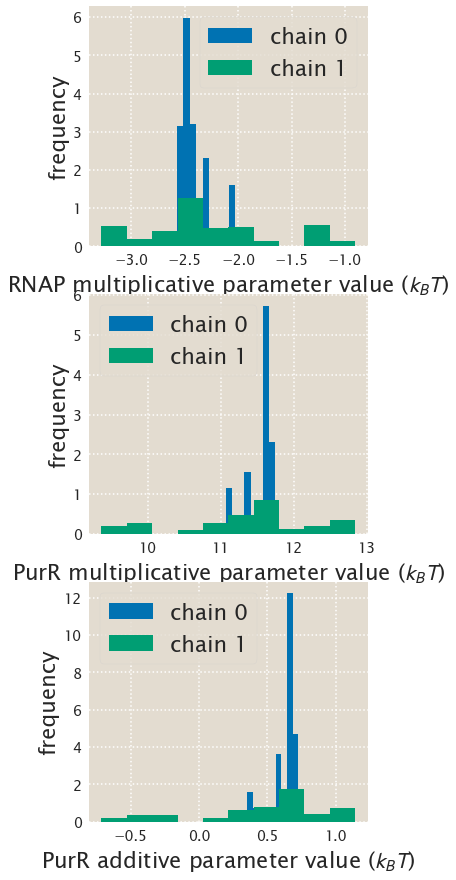

In [14]:
# make empty array to save parameter values
purT_median_param = np.empty((len(purT_params)-1,len(names)))

# make empty array to save parameter 95th percentile values
purT_hpd_param = [[],[],[]]

# plot histograms from the MCMC chains for each parameter
fig, ax = plt.subplots(3,1, figsize=(5,5*(len(purT_params)-1)))
    
for i, name in enumerate(names):
    df = h5py.File(name,'r')
    em = df['chain']
    '''for each feature, filter out burn in values and those with extremely low information content. 
    then display each walker value for the lowest temperature walkers. Take median and display.'''

    for feat in range(len(purT_params)-1):
        #9 is the lowest temperature chain, which is given by first index. The 100: in the third term removes a burn in
        all = em[9,:,burnin:,feat].ravel()
        all_IM = em[9,:,burnin:,3].ravel()
        
        #filter out any extremely low values. 
        all_nz = all_IM > (100)
        all_IM = all_IM[all_nz.nonzero()]

        all = all[all_nz.nonzero()]
        all_nz = all_IM > 100
        all_IM_v2 = all_IM[all_nz.nonzero()]
        all_v2 = all[all_nz.nonzero()]
        
        all_IM = em[9,:,burnin:,3].ravel()
        ax[feat].hist(all_v2, label = 'chain '+str(i), normed=True)
        ax[feat].set_xlabel(str(purT_params[feat])+' parameter value ($k_B T$)')
        ax[feat].set_ylabel('frequency')
        ax[feat].legend()
        
        # calculate median and gather values to calculate hpd from chains
        purT_median_param[feat,i] = np.median(all_v2)
        purT_hpd_param[feat] = np.append(purT_hpd_param[feat], all_v2)
        

Now lets summarize the values across the different MCMC chains. Note that errors are estimated from 95% highest probability density region given by the set of
            samples.

In [18]:
# for i, param in enumerate(purT_median_param.mean(axis=1)):
#     print(purT_params[i] + ': ' + str(-round(purT_median_param.mean(axis=1)[i],2)) + ' k_B T')
    
for i, param in enumerate(purT_median_param.mean(axis=1)):
    hpd = utils.hpd(purT_hpd_param[i], 0.95)
    yerr = [purT_median_param.mean(axis=1)[i]-hpd[0], hpd[1]-purT_median_param.mean(axis=1)[i]]
    print(purT_params[i] + ': ' + str(-round(purT_median_param.mean(axis=1)[i],1)) +  
          ' + ' + str(+round(yerr[1],1)) + ' - ' + str(round(yerr[0],1)) + ' k_B T')

RNAP multiplicative: 2.4 + 0.4 - 0.1 k_B T
PurR multiplicative: -11.6 + 0.2 - 0.5 k_B T
PurR additive: -0.6 + 0.1 - 0.3 k_B T


# _dgoR_ promoter, Estimation of CRP-RNAP interaction.

- Sort-Seq data was from experiment with JK10 strain (grown in EZrich media, 500 $\mu$M cAMP).

Next we consider the _dgoR_ promoter. While we found the promoter to be
quite complex, here we use data from the JK10 strain (see Supplemental Section
G4.5) where activation by CRP appeared to dominate transcription.
Here we apply the model used by Kinney _et al._ (Kinney _et al._, 2010), which
consists of a binding site for RNAP and CRP, but also includes an interaction
energy between these two proteins. Again using fugacity terms to describe the
availability of each protein, this will be given by,

\begin{equation}
P_{bound} = \frac{\lambda_p e^{-\beta \varepsilon_p} + \lambda_a \cdot \lambda_p e^{-\beta (\varepsilon_p + \varepsilon_a + \varepsilon_i)}}
{1 + \lambda_p e^{-\beta \varepsilon_p} + \lambda_a e^{-\beta \varepsilon_a} + \lambda_a \cdot \lambda_p e^{-\beta (\varepsilon_p + \varepsilon_a + \varepsilon_i)}}.
\end{equation}
In this architecture we have the fugacity $\lambda_a$ for the activator CRP
and its binding energy to the binding site, $\varepsilon_a$. In addition,
there is an additional energy term $\varepsilon_i$ that describes the
interaction between RNAP and CRP. Again, we can write $\varepsilon_p = A_p
\cdot x_p + B_p$. We can also write the CRP binding energy as $\varepsilon_a =
A_a \cdot x_a + B_a$, where similarly, $A_a$ is the scale factor, $x_a$ is the
gauge-fixed energy prediction, and $B_a$ is an additive shift.  Using parallel
tempering MCMC to sample  $p(P_{bound} \vert \{S, f\})$, we obtained the
following values: $\varepsilon_i = -7.3 k_B T$, $A_a= -13.6 k_B T$, $\lambda_a
e^{-\beta B_a} = e^{-1.89}$, and $A_p=-12.7 k_B T$.


Again, lets first look at the posterior probability values (mutual information) from the MCMC chains. 

Like above, each chain has 10000 steps, and 1 out of every ten is saved, with 30 parallel tempering 'walkers'.

We can first take a look at the posterior probability values (i.e. the mutual information; Kinney et al. 2010) from the MCMC chains. All of these seem to be single peaked, except chain0. This is to be ensure they peak in a reasonable way and that there are no major degeneracies.

The paramters that were fit with the model:  
- RNAP multiplicative parameter  
- CRP  multiplicative parameter  
- CRP additive parameter
- RNAP-CRP interaction parameter

There h5py files contains either the fit parameters or the mutual information of the model against the data:  
- feature = 0: RNAP multiplicative parameter  , $A_p$
- feature = 1: CRP  multiplicative parameter  , $A_a$
- feature = 2: CRP additive parameter , $\lambda_a e^{-\beta B_a}$
- feature = 3: RNAP-CRP interaction parameter , $\varepsilon_i$
- feature = 4: Mutual information of model


In [5]:
# values in MCMC chain (first three are the parameter values that could be fit)
dgoR_params = {0:'RNAP multiplicative', 1:'CRP multiplicative', 
               2:'CRP additive', 3:'interaction', 4:'mutual information'}

# burn in period, we will ignore the first 100 values in our chains (i.e. 1000 steps)
burnin = 100

# find files
names = glob.glob('input_data/JK10_chain_*')


In [6]:
# fig, ax = plt.subplots(len(names),1, figsize=(5,5*len(names)))

# for i, name in enumerate(names):
#     df = h5py.File(name,'r')
#     em = df['chain']
#     all_IM = em[9,:,burnin:,4].ravel()
#     all_nz = all_IM > 100
#     all_IM = all_IM[all_nz.nonzero()]
#     ax[i].hist(all_IM, label= ('chain ' + name[-6]))
#     ax[i].set_xlabel('mutual information')
#     ax[i].set_ylabel('frequency')
#     ax[i].legend()

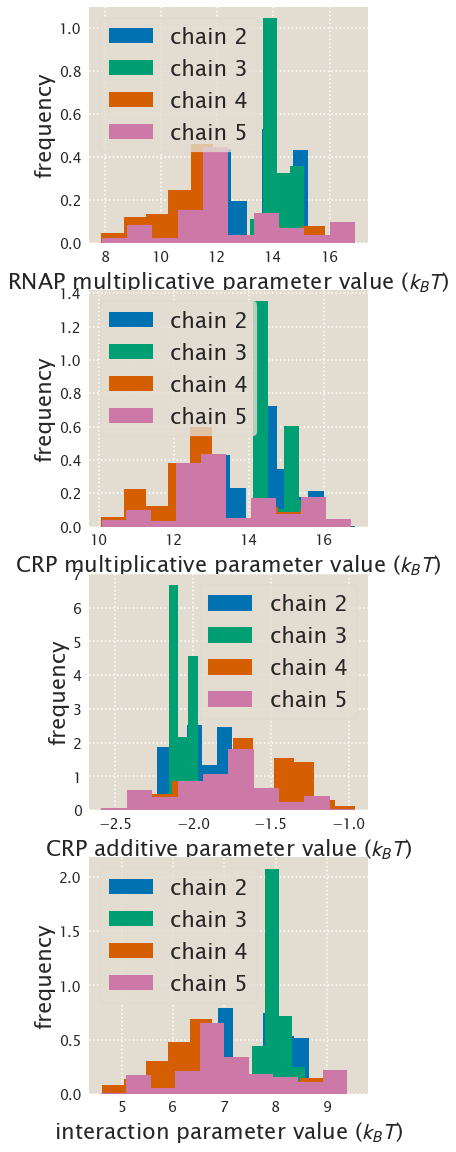

In [7]:
# make empty array to save parameter values
dgoR_median_param = np.empty((len(dgoR_params)-1,len(names)))
# make empty array to save parameter 95th percentile values
# dgoR_hpd_param = np.empty((len(dgoR_params)-1,len(names),2))
dgoR_hpd_param_0 = [[],[],[],[]]



# plot histograms from the MCMC chains for each parameter
fig, ax = plt.subplots((len(dgoR_params)-1),1, figsize=(5,5*(len(dgoR_params)-1)))
    
for i, name in enumerate(names):
#     if i !=0:
#         continue

    df = h5py.File(name,'r')
    em = df['chain']
    '''for each feature, filter out burn in values and those with extremely low information content. 
    then display each walker value for the lowest temperature walkers. Take median and display.'''

    for feat in range(len(dgoR_params)-1):
        # 9 is the lowest temperature chain, which is given by first index. The 100: in the third term removes a burn in
        all = em[9,:,burnin:,feat].ravel()
        all_IM = em[9,:,burnin:,4].ravel()
        
        #filter out any extremely low values. 
        all_nz = all_IM > (100)
        all_IM = all_IM[all_nz.nonzero()]

        all = all[all_nz.nonzero()]
        all_nz = all_IM > 100
        all_IM_v2 = all_IM[all_nz.nonzero()]
        all_v2 = all[all_nz.nonzero()]

        # note that for the RNAP parameter there appears to 
        # be some values < 0,  that don't seem reasonable. Likewise
        # this
        if feat == 0:
            all_v2 = all_v2[all_v2 > 0]
        if feat == 2:
            all_v2 = all_v2[all_v2 < 0]
        if feat == 3:
            all_v2 = all_v2[all_v2 > 0]
            
        
#         all_IM = em[9,:,burnin:,4].ravel()
        ax[feat].hist(all_v2, label = 'chain '+name[-6], normed=True)
        ax[feat].set_xlabel(str(dgoR_params[feat])+' parameter value ($k_B T$)')
        ax[feat].set_ylabel('frequency')
        ax[feat].legend()
        

        # calculate median and highest posterior probability value from chain
        dgoR_median_param[feat,i] = np.median(all_v2)        
        dgoR_hpd_param_0[feat] = np.append(dgoR_hpd_param_0[feat], all_v2)


Now lets summarize the values across the different MCMC chains. Note that errors are estimated from 95% highest probability density region given by the set of
            samples.

In [11]:
for i, param in enumerate(dgoR_median_param.mean(axis=1)):
    hpd = utils.hpd(dgoR_hpd_param_0[i], 0.95)
    yerr = [dgoR_median_param.mean(axis=1)[i]-hpd[0], hpd[1]-dgoR_median_param.mean(axis=1)[i]]
    print(dgoR_params[i] + ': ' + str(-round(dgoR_median_param.mean(axis=1)[i],1)) +  
        ' + ' + str(round(yerr[0],1)) + ' - ' + str(+round(yerr[1],1)) + ' k_B T')

RNAP multiplicative: -12.7 + 3.4 - 2.8 k_B T
CRP multiplicative: -13.6 + 2.6 - 2.2 k_B T
CRP additive: 1.9 + 0.4 - 0.6 k_B T
interaction: -7.3 + 1.9 - 1.4 k_B T


In [150]:
# We can also view the distributions using the corner tool
# import corner
# fig = corner.corner(all_v2,labels=["RNAP mult", " CRP  mult", "CRP add.", "RNAP-CRP\n interaction"])
